### Trigo

In [40]:
import torch.nn.functional as F
from torch_explain.nn.concepts import ConceptReasoningLayer, IntpLinearLayer1, IntpLinearLayer2, IntpLinearLayer3
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_explain as te
from torch_explain import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import logging
import warnings
warnings.filterwarnings('ignore')
# Set the logging level for matplotlib to WARNING to suppress debug information
logging.getLogger('matplotlib').setLevel(logging.WARNING)


PATH = 'models/'

In [41]:
from torch_explain.datasets import trigonometry
x, c, y = trigonometry(10000)

In [42]:
y = F.one_hot(y.long().ravel()).float()

LLR 1

In [43]:
isBias = True

In [44]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 16),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(16, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer1(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [45]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR1_Trigonometry_3.pth')))

<All keys matched successfully>

In [46]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [47]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 2]), torch.Size([10000, 3, 2]), torch.Size([10000, 2]))

In [48]:
df_all = pd.DataFrame()
df_all['c0'] = c[:,0].detach().numpy()
df_all['c1'] = c[:,1].detach().numpy()
df_all['c2'] = c[:,2].detach().numpy()
df_all['w0_y0'] = weights[:,0,0].detach().numpy()
df_all['w1_y0'] = weights[:,1,0].detach().numpy()
df_all['w2_y0'] = weights[:,1,0].detach().numpy()
df_all['w0_y1'] = weights[:,0,1].detach().numpy()
df_all['w1_y1'] = weights[:,1,1].detach().numpy()
df_all['w2_y1'] = weights[:,1,1].detach().numpy()
df_all['b_y0'] = biases[:,0].detach().numpy()
df_all['b_y1'] = biases[:,1].detach().numpy()
df_all['y0'] = y[:,0].detach().numpy()
df_all['y1'] = y[:,1].detach().numpy()
df_all['y_pred0'] = y_pred[:,0].detach().numpy()
df_all['y_pred1'] = y_pred[:,1].detach().numpy()

In [49]:
temp = df_all[['y_pred0', 'y_pred1']].apply(lambda x: torch.sigmoid(torch.tensor([x[0], x[1]])).numpy(), axis=1).to_numpy()
arr_as_list = [list(sub_array) for sub_array in temp]
arr_converted = np.array(arr_as_list)
column_0 = arr_converted[:, 0]
column_1 = arr_converted[:, 1]

df_all['y_pred0'] = column_0
df_all['y_pred1'] = column_1

In [50]:
df_all.head()

,c0,c1,c2,w0_y0,w1_y0,w2_y0,w0_y1,w1_y1,w2_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
0,1.0,0.0,1.0,5.340839e-04,6.537935e-05,6.537935e-05,9.991492e-01,0.999854,0.999854,-3.551677,2.040658,0.0,1.0,0.027895,0.982713
1,1.0,0.0,0.0,2.003378e-04,1.208131e-04,1.208131e-04,9.996803e-01,0.999508,0.999508,-2.974184,1.907293,0.0,1.0,0.048615,0.948191
2,1.0,1.0,0.0,2.484009e-07,3.007687e-08,3.007687e-08,9.999995e-01,1.000000,1.000000,-4.722922,3.411554,0.0,1.0,0.008811,0.995555
3,1.0,0.0,0.0,9.986357e-01,9.772743e-01,9.772743e-01,8.900142e-04,0.013086,0.013086,2.699772,-3.684276,1.0,0.0,0.975836,0.024521
4,1.0,0.0,0.0,1.000000e+00,2.878137e-04,2.878137e-04,1.977676e-16,0.996387,0.996387,3.396959,-4.201967,1.0,0.0,0.987835,0.014745


In [51]:
df0= df_all[['c0', 'c1', 'w0_y0', 'w1_y0', 'w2_y0', 'b_y0']][df_all['y_pred0'] > 0.5]
df1= df_all[['c0', 'c1', 'w0_y1', 'w1_y1', 'w2_y1','b_y1']][df_all['y_pred1'] > 0.5]

In [52]:
df0_mean = df0[['w0_y0', 'w1_y0', 'w2_y0', 'b_y0']].mean(axis=0)
df0_mean

w0_y0    0.728903
w1_y0    0.657433
w2_y0    0.657433
b_y0     2.507509
dtype: float32

In [53]:
df1_mean = df1[['w0_y1', 'w1_y1', 'w2_y1', 'b_y1']].mean(axis=0)
df1_mean

w0_y1    0.974039
w1_y1    0.975937
w2_y1    0.975937
b_y1     1.534659
dtype: float32

In [54]:
import random
def plotting_function(df_1):

    fig, ax = plt.subplots()

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # Assuming df_1 is correctly calculated before this snippet
    bar_width = 0.5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
    colors = random.sample(colors, len(df_1))
    hatches = ['/', '-', '|', '\\']  # Different hatches for each bar
    hatches = random.sample(hatches, len(df_1))
    bars = ax.bar(df_1.index, softmax(df_1), bar_width, color=colors, edgecolor='black')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        
    ax.set_ylabel('Mean Absolute Value')
    ax.set_title('Mean Absolute Values of Weights (without Softmax)')
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    ax.set_ylim([0, 0.4])

    # Enhanced label positioning
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

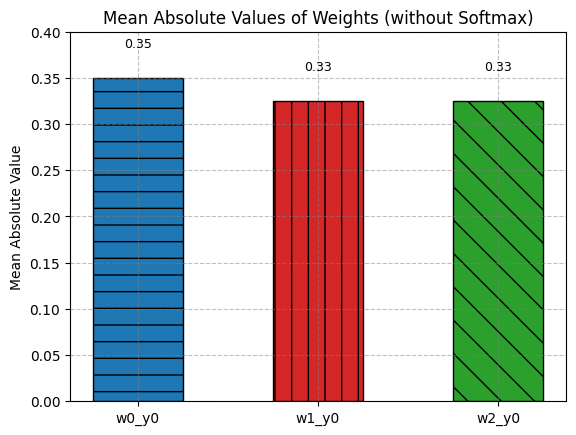

In [55]:
plotting_function(df0_mean[['w0_y0', 'w1_y0', 'w2_y0']])

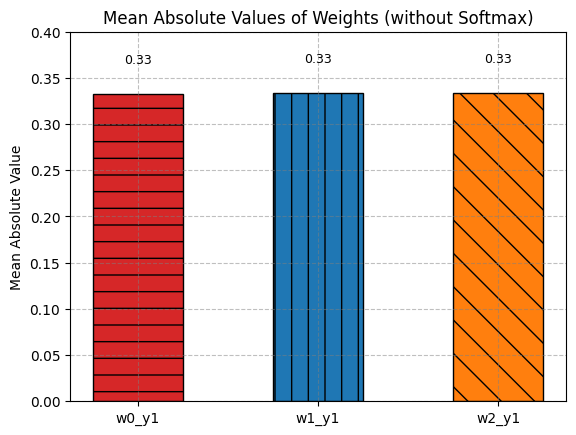

In [56]:
plotting_function(df1_mean[['w0_y1', 'w1_y1', 'w2_y1']])

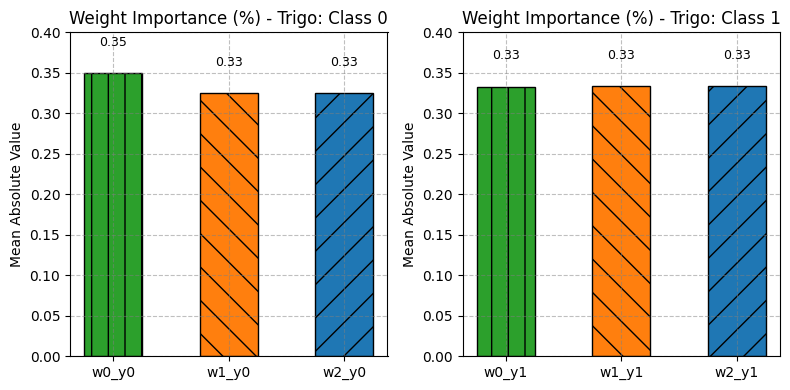

In [57]:
def plotting_function_combined(df0_mean, df1_mean):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def plot_single(ax, df, title, colors, hatches):
        bar_width = 0.5
        bars = ax.bar(df.index, softmax(df), bar_width, color=colors, edgecolor='black')
        
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        ax.set_ylabel('Mean Absolute Value')
        ax.set_title(title)
        ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
        ax.set_ylim([0, 0.4])

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hatches = ['/', '-', '|', '\\']
    random.shuffle(colors)
    random.shuffle(hatches)

    plot_single(axes[0], df0_mean, "Weight Importance (%) - Trigo: Class 0", colors[:], hatches[:])
    plot_single(axes[1], df1_mean, "Weight Importance (%) - Trigo: Class 1", colors[:], hatches[:])

    plt.tight_layout()
    plt.show()


plotting_function_combined(df0_mean[['w0_y0', 'w1_y0', 'w2_y0']], df1_mean[['w0_y1', 'w1_y1', 'w2_y1']])

In [58]:
df000= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] < 0.5)]
df001= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] > 0.5)]
df010= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] < 0.5)]
df011= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] > 0.5)]
df100= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] < 0.5)]
df101= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] > 0.5)]
df110= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] < 0.5)]
df111= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] > 0.5)]

In [59]:
# concat all Series df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0) into a DataFrame
df_mean = pd.concat([df000.mean(axis=0), \
                    df001.mean(axis=0), \
                        df010.mean(axis=0), \
                        df011.mean(axis=0), \
                            df100.mean(axis=0), \
                                df101.mean(axis=0), \
                                    df110.mean(axis=0), \
                                        df111.mean(axis=0), \
                                                    
                     ], axis=1)
df_mean.columns = ['000', '001', '010', '011','100', '101', '110', '111']
df_mean = df_mean.T

In [60]:
df_mean.round(3)

,c0,c1,c2,w0_y0,w1_y0,w2_y0,w0_y1,w1_y1,w2_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
000,0.0,0.0,0.0,0.864,0.701,0.701,0.128,0.193,0.193,3.171,-3.283,1.000,0.000,0.959,0.038
001,0.0,0.0,1.0,0.693,0.221,0.221,0.315,0.704,0.704,2.267,-2.938,0.898,0.102,0.885,0.122
010,0.0,1.0,0.0,0.267,0.915,0.915,0.720,0.084,0.084,2.412,-3.130,0.906,0.094,0.889,0.113
011,0.0,1.0,1.0,0.172,0.412,0.412,0.828,0.572,0.572,-1.132,-0.298,0.406,0.594,0.437,0.585
100,1.0,0.0,0.0,0.892,0.520,0.520,0.103,0.402,0.402,2.091,-2.926,0.896,0.104,0.871,0.132
101,1.0,0.0,1.0,0.370,0.133,0.133,0.620,0.848,0.848,-1.567,0.085,0.383,0.617,0.387,0.629
110,1.0,1.0,0.0,0.381,0.371,0.371,0.602,0.615,0.615,-1.419,-0.056,0.402,0.598,0.405,0.615
111,1.0,1.0,1.0,0.008,0.011,0.011,0.989,0.987,0.987,-3.132,1.331,0.011,0.989,0.057,0.975


LLR 3

In [61]:
embedding_size = 16
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(x.shape[1], 16),
    torch.nn.LeakyReLU(),
    te.nn.ConceptEmbedding(16, c.shape[1], embedding_size),
)

task_predictor = IntpLinearLayer3(embedding_size, y.shape[1], bias=isBias)
model = torch.nn.Sequential(concept_encoder, task_predictor)

In [62]:
import os
model.load_state_dict(torch.load(os.path.join(PATH,'model_state_dict_LLR3_Trigonometry_3.pth')))

<All keys matched successfully>

In [63]:
cem = model[0]
llr = model[1]
cem.eval()
llr.eval()
c_emb , c_pred = cem(x)
y_pred, weights, biases = llr(c_emb, c_pred, return_params=True)

In [64]:
y_pred.shape, weights.shape, biases.shape

(torch.Size([10000, 2]), torch.Size([10000, 3, 2]), torch.Size([10000, 2]))

In [65]:
df_all = pd.DataFrame()
df_all['c0'] = c[:,0].detach().numpy()
df_all['c1'] = c[:,1].detach().numpy()
df_all['c2'] = c[:,2].detach().numpy()
df_all['w0_y0'] = weights[:,0,0].detach().numpy()
df_all['w1_y0'] = weights[:,1,0].detach().numpy()
df_all['w2_y0'] = weights[:,1,0].detach().numpy()
df_all['w0_y1'] = weights[:,0,1].detach().numpy()
df_all['w1_y1'] = weights[:,1,1].detach().numpy()
df_all['w2_y1'] = weights[:,1,1].detach().numpy()
df_all['b_y0'] = biases[:,0].detach().numpy()
df_all['b_y1'] = biases[:,1].detach().numpy()
df_all['y0'] = y[:,0].detach().numpy()
df_all['y1'] = y[:,1].detach().numpy()
df_all['y_pred0'] = y_pred[:,0].detach().numpy()
df_all['y_pred1'] = y_pred[:,1].detach().numpy()

In [66]:
temp = df_all[['y_pred0', 'y_pred1']].apply(lambda x: torch.sigmoid(torch.tensor([x[0], x[1]])).numpy(), axis=1).to_numpy()
arr_as_list = [list(sub_array) for sub_array in temp]
arr_converted = np.array(arr_as_list)
column_0 = arr_converted[:, 0]
column_1 = arr_converted[:, 1]

df_all['y_pred0'] = column_0
df_all['y_pred1'] = column_1

In [67]:
df_all.head()

,c0,c1,c2,w0_y0,w1_y0,w2_y0,w0_y1,w1_y1,w2_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
0,1.0,0.0,1.0,-0.997761,-0.977756,-0.977756,0.997538,0.973766,0.973766,-1.897603,1.920929,0.0,1.0,0.020016,0.980408
1,1.0,0.0,0.0,-0.999792,-0.981385,-0.981385,0.999817,0.971122,0.971122,-1.673955,1.684532,0.0,1.0,0.064540,0.936098
2,1.0,1.0,0.0,-1.000000,-0.999999,-0.999999,1.000000,0.999999,0.999999,-2.887628,2.889939,0.0,1.0,0.007483,0.992534
3,1.0,0.0,0.0,0.999095,0.999589,0.999589,-0.998540,-0.999537,-0.999537,2.236089,-2.293340,1.0,0.0,0.962137,0.035851
4,1.0,0.0,0.0,1.000000,0.999565,0.999565,-1.000000,-0.999451,-0.999451,3.730467,-3.772136,1.0,0.0,0.991255,0.008391


In [68]:
df0= df_all[['c0', 'c1', 'w0_y0', 'w1_y0', 'w2_y0', 'b_y0']][df_all['y_pred0'] > 0.5]
df1= df_all[['c0', 'c1', 'w0_y1', 'w1_y1', 'w2_y1','b_y1']][df_all['y_pred1'] > 0.5]

In [69]:
df0_mean = df0[['w0_y0', 'w1_y0', 'w2_y0', 'b_y0']].mean(axis=0)
df0_mean

w0_y0    0.882634
w1_y0    0.872530
w2_y0    0.872530
b_y0     2.446298
dtype: float32

In [70]:
df1_mean = df1[['w0_y1', 'w1_y1', 'w2_y1', 'b_y1']].mean(axis=0)
df1_mean

w0_y1    0.883960
w1_y1    0.887651
w2_y1    0.887651
b_y1     1.620309
dtype: float32

In [71]:
import random
def plotting_function(df_1):

    fig, ax = plt.subplots()

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # Assuming df_1 is correctly calculated before this snippet
    bar_width = 0.5
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each bar
    colors = random.sample(colors, len(df_1))
    hatches = ['/', '-', '|', '\\']  # Different hatches for each bar
    hatches = random.sample(hatches, len(df_1))
    bars = ax.bar(df_1.index, softmax(df_1), bar_width, color=colors, edgecolor='black')

    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
        
    ax.set_ylabel('Mean Absolute Value')
    ax.set_title('Mean Absolute Values of Weights (without Softmax)')
    ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
    ax.set_ylim([0, 0.4])

    # Enhanced label positioning
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

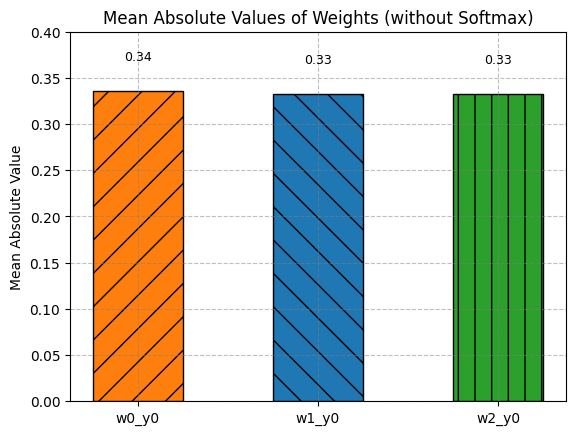

In [72]:
plotting_function(df0_mean[['w0_y0', 'w1_y0', 'w2_y0']])

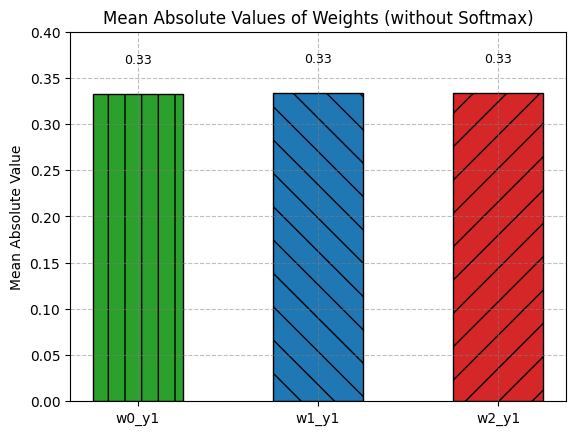

In [73]:
plotting_function(df1_mean[['w0_y1', 'w1_y1', 'w2_y1']])

In [74]:
df000= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] < 0.5)]
df001= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] > 0.5)]
df010= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] < 0.5)]
df011= df_all[(df_all['c0'] < 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] > 0.5)]
df100= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] < 0.5)]
df101= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] < 0.5) & (df_all['c2'] > 0.5)]
df110= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] < 0.5)]
df111= df_all[(df_all['c0'] > 0.5) & (df_all['c1'] > 0.5) & (df_all['c2'] > 0.5)]

In [75]:
# concat all Series df00.mean(axis=0), df01.mean(axis=0), df10.mean(axis=0), df11.mean(axis=0) into a DataFrame
df_mean = pd.concat([df000.mean(axis=0), \
                    df001.mean(axis=0), \
                        df010.mean(axis=0), \
                        df011.mean(axis=0), \
                            df100.mean(axis=0), \
                                df101.mean(axis=0), \
                                    df110.mean(axis=0), \
                                        df111.mean(axis=0), \
                                                    
                     ], axis=1)
df_mean.columns = ['000', '001', '010', '011','100', '101', '110', '111']
df_mean = df_mean.T

In [76]:
df_mean.round(3)

,c0,c1,c2,w0_y0,w1_y0,w2_y0,w0_y1,w1_y1,w2_y1,b_y0,b_y1,y0,y1,y_pred0,y_pred1
000,0.0,0.0,0.0,0.998,0.998,0.998,-0.999,-0.999,-0.999,3.219,-3.219,1.000,0.000,0.961,0.040
001,0.0,0.0,1.0,0.822,0.639,0.639,-0.832,-0.647,-0.647,2.184,-2.182,0.898,0.102,0.882,0.119
010,0.0,1.0,0.0,0.547,0.803,0.803,-0.564,-0.803,-0.803,2.239,-2.241,0.906,0.094,0.886,0.116
011,0.0,1.0,1.0,-0.149,-0.153,-0.153,0.134,0.157,0.157,-0.313,0.266,0.406,0.594,0.415,0.583
100,1.0,0.0,0.0,0.781,0.713,0.713,-0.775,-0.734,-0.734,2.116,-2.111,0.896,0.104,0.873,0.128
101,1.0,0.0,1.0,-0.237,-0.328,-0.328,0.233,0.301,0.301,-0.647,0.684,0.383,0.617,0.376,0.625
110,1.0,1.0,0.0,-0.227,-0.202,-0.202,0.235,0.195,0.195,-0.431,0.429,0.402,0.598,0.393,0.608
111,1.0,1.0,1.0,-0.975,-0.983,-0.983,0.975,0.983,0.983,-1.472,1.420,0.011,0.989,0.022,0.977


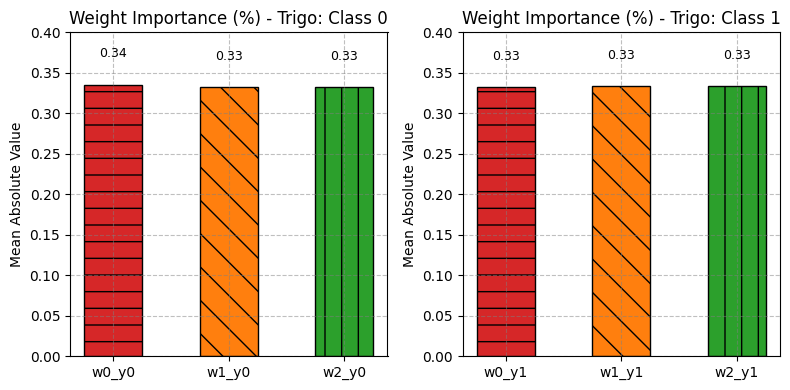

In [77]:
def plotting_function_combined(df0_mean, df1_mean):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def plot_single(ax, df, title, colors, hatches):
        bar_width = 0.5
        bars = ax.bar(df.index, softmax(df), bar_width, color=colors, edgecolor='black')
        
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        
        ax.set_ylabel('Mean Absolute Value')
        ax.set_title(title)
        ax.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)
        ax.set_ylim([0, 0.4])

        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.2f}', ha='center', va='bottom', fontsize=9, color='black')

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    hatches = ['/', '-', '|', '\\']
    random.shuffle(colors)
    random.shuffle(hatches)

    plot_single(axes[0], df0_mean, "Weight Importance (%) - Trigo: Class 0", colors[:], hatches[:])
    plot_single(axes[1], df1_mean, "Weight Importance (%) - Trigo: Class 1", colors[:], hatches[:])

    plt.tight_layout()
    plt.show()


plotting_function_combined(df0_mean[['w0_y0', 'w1_y0', 'w2_y0']], df1_mean[['w0_y1', 'w1_y1', 'w2_y1']])